In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time, random, os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# ---------------- GPU / seed ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
manualSeed = 1234
torch.manual_seed(manualSeed); np.random.seed(manualSeed); random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# ---------------- Neural net ----------------
class Net2D(nn.Module):
    def __init__(self, n_input=2, n_output=2, n_layer=8, n_nodes=80):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)
        self.act = torch.tanh

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)  # -> [u, v]

# ---------------- Domain (1x1) and collocation points ----------------
nelx, nely = 150, 150
xs = np.linspace(0.0, 1.0, nelx+1)
ys = np.linspace(0.0, 1.0, nely+1)
X, Y = np.meshgrid(xs, ys)
pts = np.hstack([X.reshape(-1,1, order='F'), Y.reshape(-1,1, order='F')])
N_total = pts.shape[0]
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# boundary indices: right edge x = 1.0
tol = 1e-6
right_idx = np.where(np.abs(pts[:,0] - 1.0) < tol)[0]
right_idx_t = torch.tensor(right_idx, dtype=torch.long, device=device)

# ---------------- Material and loading ----------------
nu = 0.3
T = 1.0
E_node = torch.ones((N_total,1), device=device) 

# ---------------- Build single net ----------------
net_uv = Net2D(n_input=2, n_output=2, n_layer=8, n_nodes=80).to(device)

# Hard boundary condition u=v=0 on x=0
def uv_tilde(pt):
    xcoord = pt[:,0:1]
    out = net_uv(pt)
    return xcoord * out  # enforce u=v=0 when x=0

# ---------------- Energy computation ----------------
def energy_loss_barrier(alpha=1e-2, beta=1e-2, eps=1e-8):
    uv = uv_tilde(data)
    u, v = uv[:,0:1], uv[:,1:2]

    # Derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

    du_x = du[:,0:1]; du_y = du[:,1:2]
    dv_x = dv[:,0:1]; dv_y = dv[:,1:2]

    # Strains
    ex = du_x
    ey = dv_y
    gamma_xy = du_y + dv_x

    # Constitutive law
    G = E_node / (2.0*(1.0+nu))
    lam = E_node * nu / (1.0 - nu**2)

    sx = 2.0*G*ex + lam*(ex + ey)
    sy = 2.0*G*ey + lam*(ex + ey)
    txy = G * gamma_xy

    # Internal energy
    w_density = 0.5*(sx*ex + sy*ey + txy*gamma_xy)
    Eint = torch.mean(w_density)

    # External energy
    u_boundary = u[right_idx_t]
    Eext = T * torch.mean(u_boundary)

    loss = Eint - Eext

    return loss, Eint, Eext

# ---------------- Training ----------------
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(net_uv.parameters(), lr=lr)
loss_history = []

print("Pretraining with Adam...")
start = time.time()

for ep in range(epochs):
    optimizer.zero_grad()
    loss, Eint, Eext = energy_loss_barrier()
    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)
    if ep % 200 == 0 or ep == epochs-1:
        print(f"Epoch {ep:5d}/{epochs} | loss={loss_val:.6e} | Eint={Eint.item():.4e} | Eext={Eext.item():.4e}")

print(f"Training done in {(time.time()-start):.2f}s")

 


Device: cuda
Pretraining with Adam...
Epoch     0/2000 | loss=-1.854760e-01 | Eint=2.6918e-02 | Eext=2.1239e-01
Epoch   200/2000 | loss=-4.920921e-01 | Eint=4.9176e-01 | Eext=9.8386e-01
Epoch   400/2000 | loss=-4.926061e-01 | Eint=4.9238e-01 | Eext=9.8499e-01
Epoch   600/2000 | loss=-4.928620e-01 | Eint=4.9267e-01 | Eext=9.8554e-01
Epoch   800/2000 | loss=-4.930471e-01 | Eint=4.9267e-01 | Eext=9.8572e-01
Epoch  1000/2000 | loss=-4.933133e-01 | Eint=4.9259e-01 | Eext=9.8590e-01
Epoch  1200/2000 | loss=-4.936018e-01 | Eint=4.8622e-01 | Eext=9.7982e-01
Epoch  1400/2000 | loss=-4.939007e-01 | Eint=4.9363e-01 | Eext=9.8753e-01
Epoch  1600/2000 | loss=-4.941305e-01 | Eint=4.9037e-01 | Eext=9.8451e-01
Epoch  1800/2000 | loss=-4.944127e-01 | Eint=4.9103e-01 | Eext=9.8544e-01
Epoch  1999/2000 | loss=-4.947284e-01 | Eint=4.9351e-01 | Eext=9.8823e-01
Training done in 42.14s


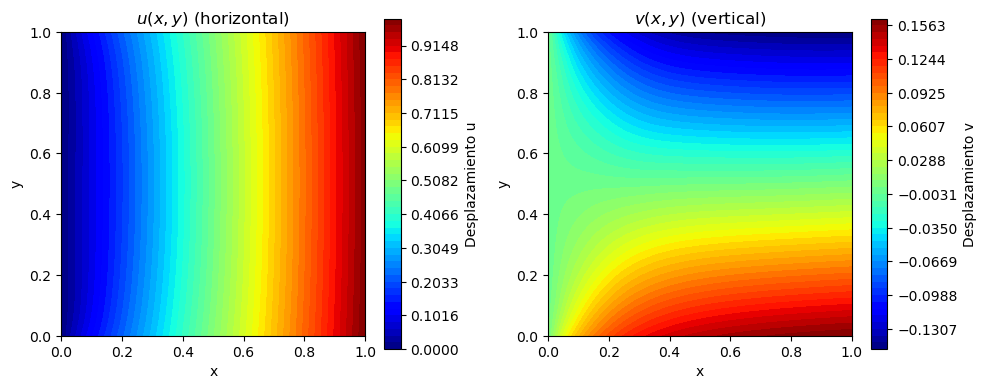

In [4]:
# ---------------- Postprocessing: displacement field ----------------
net_uv.eval()
with torch.no_grad():
    uv_pred = uv_tilde(data).cpu().numpy()
u_np = uv_pred[:, 0].reshape((nely + 1, nelx + 1), order='F')
v_np = uv_pred[:, 1].reshape((nely + 1, nelx + 1), order='F')

# ---------------- Plot displacement fields with contour levels ----------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
X, Y = np.meshgrid(x, y)

# Definir niveles automáticos basados en los valores
levels_u = np.linspace(u_np.min(), u_np.max(), 50)
levels_v = np.linspace(v_np.min(), v_np.max(), 50)

# --- u(x,y) horizontal ---
cf0 = axs[0].contourf(X, Y, u_np, levels=levels_u, cmap='jet')
axs[0].set_title(r'$u(x,y)$ (horizontal)', fontsize=12)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
plt.colorbar(cf0, ax=axs[0], label='Desplazamiento u')

# --- v(x,y) vertical ---
cf1 = axs[1].contourf(X, Y, v_np, levels=levels_v, cmap='jet')
axs[1].set_title(r'$v(x,y)$ (vertical)', fontsize=12)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')
plt.colorbar(cf1, ax=axs[1], label='Desplazamiento v')

plt.tight_layout()
plt.show()

Training PINN for traction test...
Epoch     0 | Loss: 2.323481e+22
Epoch   500 | Loss: 2.040671e+22
Epoch  1000 | Loss: 1.832745e+22
Epoch  1500 | Loss: 1.654690e+22
Epoch  2000 | Loss: 1.498134e+22
Epoch  2500 | Loss: 1.355479e+22
Epoch  3000 | Loss: 1.221379e+22
Epoch  3500 | Loss: 1.103660e+22
Epoch  4000 | Loss: 1.001910e+22
Epoch  4500 | Loss: 9.110279e+21
Training completed in 163.9 s


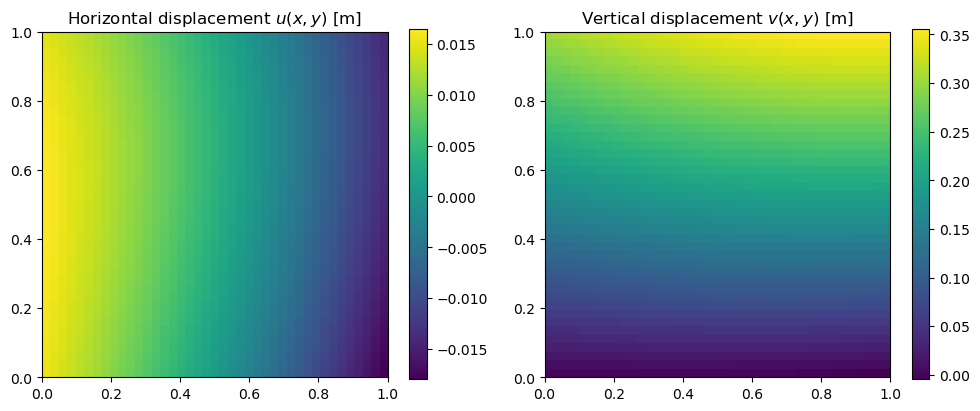

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

#%% ───────────────────────────────
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

#%% ───────────────────────────────
# Neural Network Definition
class Net(nn.Module):
    """
    Fully connected neural network for 2D elasticity (PINN approach).
    Args:
        n_input (int): input size (2 → x,y)
        n_output (int): output size (1 → u or v)
        n_layer (int): hidden layers
        n_nodes (int): neurons per hidden layer
    """
    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.Input = nn.Linear(n_input, n_nodes)
        self.Hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.Output = nn.Linear(n_nodes, n_output)
        for layer in [self.Input, self.Output] + list(self.Hidden):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        return self.Output(y)

#%% ───────────────────────────────
# Domain Definition: 1m × 1m
nelx, nely = 40, 40
x, y = np.meshgrid(np.linspace(0, 1, nelx + 1), np.linspace(0, 1, nely + 1))
y = np.flipud(y)
data = np.hstack([x.reshape(-1,1,order='F'), y.reshape(-1,1,order='F')])
data = torch.tensor(data, dtype=torch.float32, requires_grad=True, device=device)

# Boundary indices
idx_left  = np.where(data[:,0].cpu().detach().numpy() == 0)[0]
idx_right = np.where(data[:,0].cpu().detach().numpy() == 1)[0]

#%% ───────────────────────────────
# Material properties (plane stress)
E = 210e9      # Young's modulus [Pa]
nu = 0.3       # Poisson ratio
T = 1e6        # Applied traction [Pa]

G = E / (2*(1+nu))
lam = E*nu / ((1+nu)*(1-2*nu))

#%% ───────────────────────────────
# PINN setup
Net_u = Net(2,1,6,64).to(device)
Net_v = Net(2,1,6,64).to(device)
optimizer = torch.optim.AdamW(list(Net_u.parameters()) + list(Net_v.parameters()), lr=1e-3)

epochs = 5000
loss_hist = []

print("Training PINN for traction test...")

t0 = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    u = Net_u(data)
    v = Net_v(data)

    # Derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    dux, duy = du[:,0:1], du[:,1:2]
    dvx, dvy = dv[:,0:1], dv[:,1:2]

    # Strains
    ex, ey = dux, dvy
    gxy = dvx + duy

    # Stresses
    sx = lam*(ex+ey) + 2*G*ex
    sy = lam*(ex+ey) + 2*G*ey
    txy = G*gxy

    # Residuals (equilibrium equations)
    dsx = torch.autograd.grad(sx, data, torch.ones_like(sx), retain_graph=True, create_graph=True)[0][:,0:1]
    dtxy = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:,1:2]
    dsy = torch.autograd.grad(sy, data, torch.ones_like(sy), retain_graph=True, create_graph=True)[0][:,1:2]
    dtxy2 = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:,0:1]

    # PDE residuals (divergence of stress = 0)
    f_x = dsx + dtxy
    f_y = dtxy2 + dsy

    # Boundary Conditions
    # Left edge: u=v=0
    bc_left = (u[idx_left]**2 + v[idx_left]**2).mean()
    # Right edge: σx = T, τxy = 0 → enforce via stress
    bc_right = ((sx[idx_right]-T)**2 + (txy[idx_right])**2).mean()

    # Total loss
    loss = (f_x**2 + f_y**2).mean() + 10*(bc_left + bc_right)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss: {loss.item():.6e}")

print(f"Training completed in {time.time()-t0:.1f} s")

#%% ───────────────────────────────
# Postprocessing
u_pred = u.detach().cpu().numpy().reshape((nely+1, nelx+1))
v_pred = v.detach().cpu().numpy().reshape((nely+1, nelx+1))

fig, axs = plt.subplots(1,2,figsize=(10,4))
im0 = axs[0].imshow(u_pred, extent=[0,1,0,1], origin='lower', cmap='viridis')
axs[0].set_title("Horizontal displacement $u(x,y)$ [m]")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(v_pred, extent=[0,1,0,1], origin='lower', cmap='viridis')
axs[1].set_title("Vertical displacement $v(x,y)$ [m]")
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()
